<h1>Pre-Processing Dataset</h1>

In [3]:
import pandas as pd
print(pd.__version__)

2.2.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids # Untuk K-Medoids
from sklearn.preprocessing import StandardScaler, RobustScaler # Jika ada fitur yang belum di-scale
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Untuk SMOTE (jika ingin bereksperimen)
from imblearn.over_sampling import SMOTE

# Mengatur agar plot tampil inline di Jupyter Notebook (jika menggunakan)
%matplotlib inline
# Mengatur style plot
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# ===== SETUP DAN IMPORT =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Clustering
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler

# SMOTE dan evaluasi
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

# Visualisasi
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("Setup completed!")

Setup completed!


In [6]:
# ===== LOAD DATA DENGAN OPTIMASI MEMORY =====
def load_data_optimized(file_path, sample_size=None):
    """
    Load data dengan optimasi memory untuk mengatasi MemoryError
    """
    print("Loading data with memory optimization...")

    # Baca dengan chunk untuk estimasi ukuran
    chunk_size = 100000
    chunks = []
    total_rows = 0

    # Jika ingin sample, baca seluruh data terlebih dahulu
    if sample_size:
        print(f"Loading sample of {sample_size} rows...")
        df = pd.read_csv(file_path, nrows=sample_size, parse_dates=["event_time"])
    else:
        # Untuk dataset penuh, gunakan dtype optimization
        dtype_dict = {
            'product_id': 'int32',
            'category_id': 'int64',
            'price': 'float32',
            'user_id': 'int32'
        }

        try:
            df = pd.read_csv(file_path, dtype=dtype_dict, parse_dates=["event_time"])
        except MemoryError:
            print("Memory error - using sample of 1M rows")
            df = pd.read_csv(file_path, nrows=1000000, parse_dates=["event_time"])

    print(f"Loaded data shape: {df.shape}")
    return df

In [ ]:
# Load data (gunakan sample jika memory terbatas)

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
data_path = "2019-Oct.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mkechinov/ecommerce-behavior-data-from-multi-category-store",
  data_path,
)

print("First 5 records:", df.head())


Loaded shape: (5000, 9)
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                                  NaN  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa       NaN   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   

                           user_session  
0  72d76fde-8bb3-4e00-8c23-a032dfed738c  
1  9333dfbd-b8

In [8]:
# Data Cleaning
df = df.dropna(subset=["user_id", "user_session"])
df = df[df["event_type"].isin(["view", "cart", "remove_from_cart", "purchase"])]
print(f"Shape after cleaning: {df.shape}")

Shape after cleaning: (5000, 9)


In [9]:
# Feature Engineering
# 1. Event Counts
event_counts = (
    df.pivot_table(
        index="user_id",
        columns="event_type",
        values="product_id",
        aggfunc="count",
        fill_value=0
    )
    .rename(columns={
        'view': 'view_count',
        'cart': 'cart_count',
        'remove_from_cart': 'remove_count',
        'purchase': 'purchase_count'
    })
)

In [10]:
df['event_time'] = pd.to_datetime(df['event_time'])


In [11]:
# Pastikan event_time dalam format datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Filter hanya event pembelian
group_purchase = df[df['event_type'] == 'purchase']

# Recency
if len(group_purchase) > 0:
    last_purchase = (
        group_purchase
        .groupby('user_id')['event_time']
        .max()
        .to_frame('last_purchase_date')
    )
    current_date = df['event_time'].max()
    last_purchase['recency_days'] = (
        current_date - last_purchase['last_purchase_date']
    ).dt.days

    # Frequency
    frequency = (
        group_purchase
        .groupby('user_id')['event_time']
        .count()
        .to_frame('frequency')
    )

    # Monetary
    monetary = (
        group_purchase
        .groupby('user_id')['price']
        .sum()
        .to_frame('monetary')
    )
else:
    # Jika tidak ada purchase, buat dataframe kosong
    last_purchase = pd.DataFrame({'recency_days': []})
    frequency = pd.DataFrame({'frequency': []})
    monetary = pd.DataFrame({'monetary': []})


In [12]:
# Gabungkan fitur
data = (
    event_counts
    .join(last_purchase['recency_days'], how='left')
    .join(frequency, how='left')
    .join(monetary, how='left')
)

In [13]:
# Handle missing values
max_recency = last_purchase['recency_days'].max() if len(last_purchase) > 0 else 30
data.fillna({
    'recency_days': max_recency,
    'frequency': 0,
    'monetary': 0
}, inplace=True)

In [14]:
# ===== DATA TRANSFORMATION =====
# Log transform untuk mengatasi skewness
to_log = ['view_count', 'cart_count', 'remove_count', 'purchase_count', 'frequency', 'monetary']
for col in to_log:
    if col in data.columns:
        data[f'log_{col}'] = np.log1p(data[col])

# Pilih fitur untuk clustering
features_for_clustering = [
    'log_view_count', 'log_cart_count', 'log_remove_count',
    'log_purchase_count', 'recency_days', 'log_frequency', 'log_monetary'
]

In [15]:
# Filter fitur yang ada
available_features = [f for f in features_for_clustering if f in data.columns]
print(f"Available features for clustering: {available_features}")


Available features for clustering: ['log_view_count', 'log_cart_count', 'log_purchase_count', 'recency_days', 'log_frequency', 'log_monetary']


In [16]:
# Prepare data untuk clustering
X = data[available_features].copy()

In [17]:
# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features, index=X.index)

print("Data transformation completed!")

Data transformation completed!


<h1>Pembuatan Model Machine Learning</h1>

In [18]:
# ===== ANALISIS DISTRIBUSI DATA =====
def analyze_data_distribution(data, features):
    """Analisis distribusi data untuk menentukan need SMOTE"""

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    for i, feature in enumerate(features):
        if i < len(axes):
            axes[i].hist(data[feature], bins=50, alpha=0.7)
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # Analisis imbalance pada purchase behavior
    purchase_behavior = data['log_purchase_count'].apply(
        lambda x: 'Active Buyer' if x > 0 else 'Non Buyer'
    )

    print("Purchase Behavior Distribution:")
    print(purchase_behavior.value_counts())
    print("\nPercentage:")
    print(purchase_behavior.value_counts(normalize=True) * 100)

    return purchase_behavior

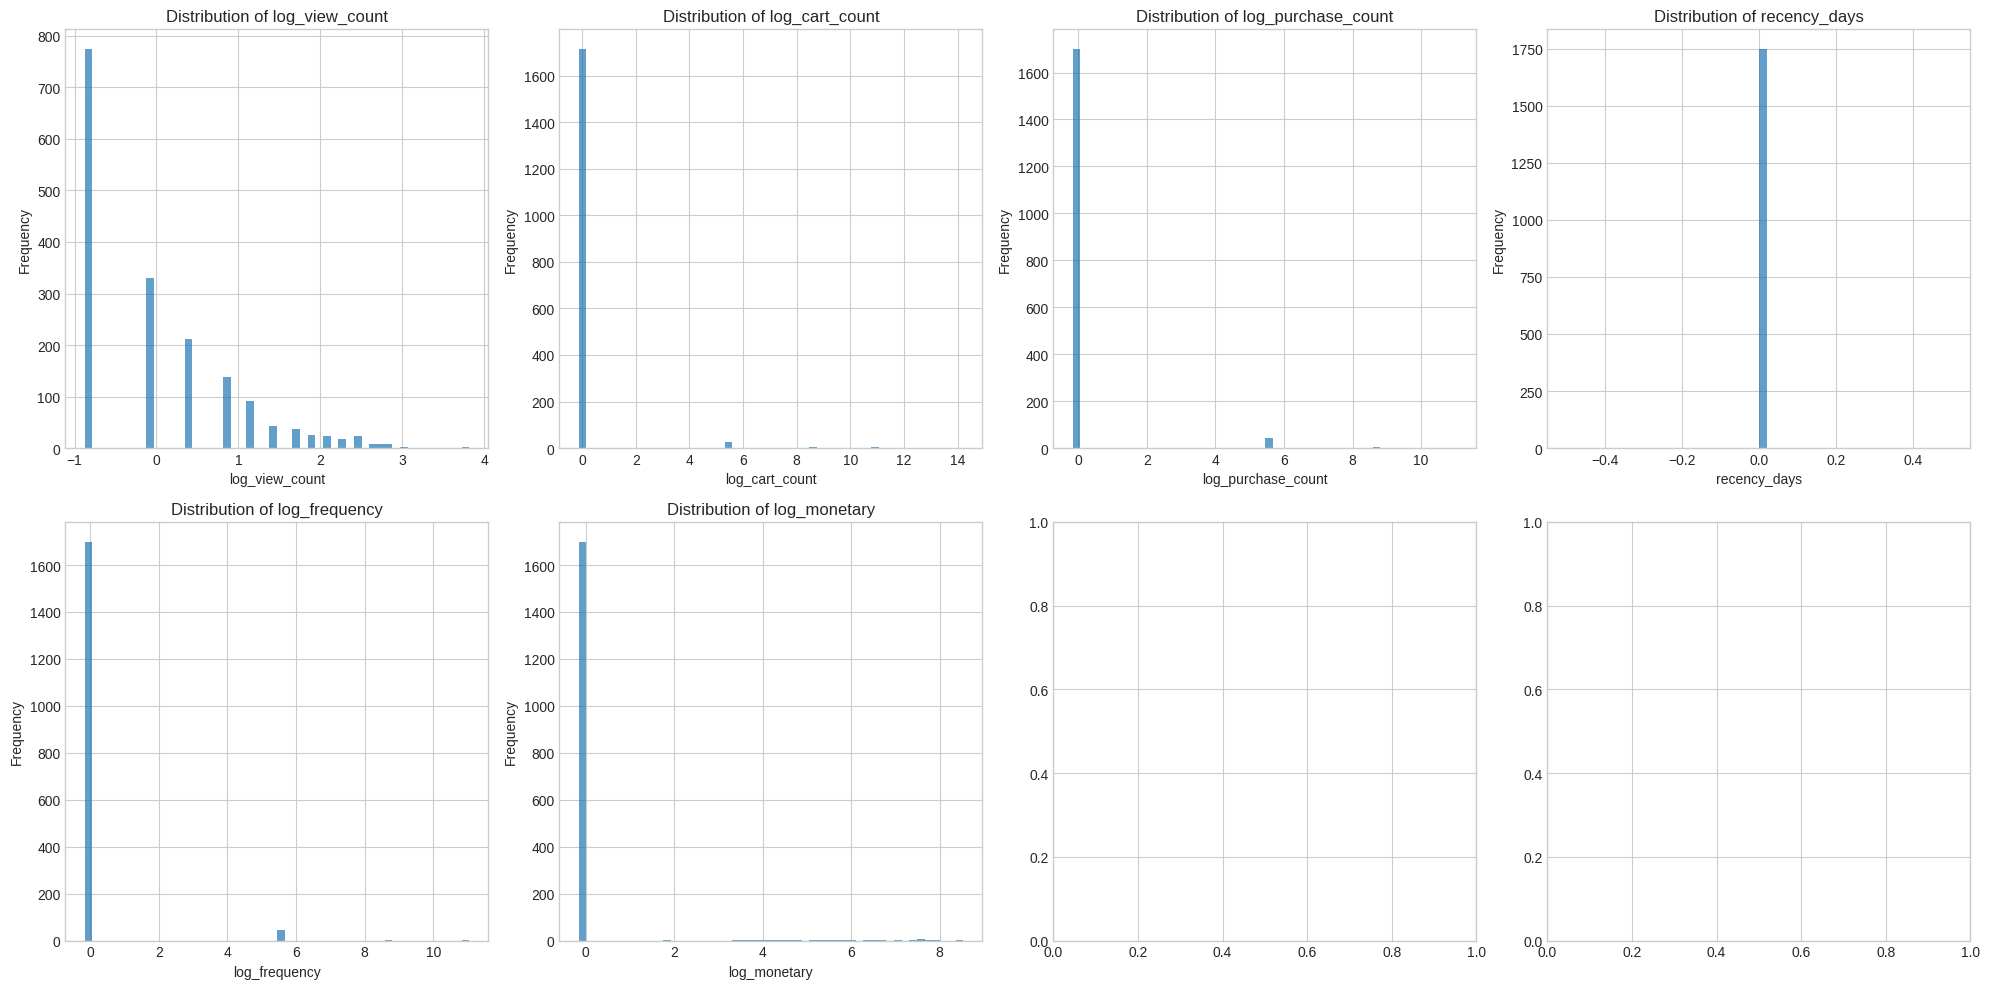

Purchase Behavior Distribution:
log_purchase_count
Non Buyer       1699
Active Buyer      48
Name: count, dtype: int64

Percentage:
log_purchase_count
Non Buyer       97.252433
Active Buyer     2.747567
Name: proportion, dtype: float64


In [19]:
# Analisis distribusi
purchase_labels = analyze_data_distribution(X_scaled_df, available_features)

In [20]:
# ===== IMPLEMENTASI SMOTE =====
def apply_smote(X, y, random_state=42):
    """Terapkan SMOTE untuk menyeimbangkan data"""

    print("Original distribution:")
    print(y.value_counts())

    # Terapkan SMOTE
    smote = SMOTE(random_state=random_state, k_neighbors=3)
    try:
        X_resampled, y_resampled = smote.fit_resample(X, y)

        print("\nAfter SMOTE:")
        print(pd.Series(y_resampled).value_counts())

        return X_resampled, y_resampled
    except Exception as e:
        print(f"SMOTE failed: {e}")
        print("Using original data without SMOTE")
        return X, y

In [21]:
# Terapkan SMOTE berdasarkan purchase behavior
X_smote, y_smote = apply_smote(X_scaled, purchase_labels)

print(f"Data shape before SMOTE: {X_scaled.shape}")
print(f"Data shape after SMOTE: {X_smote.shape}")

Original distribution:
log_purchase_count
Non Buyer       1699
Active Buyer      48
Name: count, dtype: int64

After SMOTE:
log_purchase_count
Non Buyer       1699
Active Buyer    1699
Name: count, dtype: int64
Data shape before SMOTE: (1747, 6)
Data shape after SMOTE: (3398, 6)


In [22]:
# ===== IMPLEMENTASI K-MEANS =====
def perform_kmeans_clustering(X, n_clusters_range=range(2, 11), random_state=42):
    """Implementasi K-Means dengan evaluasi berbagai jumlah cluster"""

    results = {}
    silhouette_scores = []
    inertias = []

    print("Performing K-Means clustering...")

    for n_clusters in n_clusters_range:
        # Fit K-Means
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(X)

        # Evaluasi
        silhouette_avg = silhouette_score(X, cluster_labels)
        inertia = kmeans.inertia_

        results[n_clusters] = {
            'model': kmeans,
            'labels': cluster_labels,
            'silhouette_score': silhouette_avg,
            'inertia': inertia
        }

        silhouette_scores.append(silhouette_avg)
        inertias.append(inertia)

        print(f"K={n_clusters}: Silhouette Score = {silhouette_avg:.4f}, Inertia = {inertia:.2f}")

    return results, silhouette_scores, inertias

In [23]:
# K-Means pada data original
kmeans_results_orig, sil_scores_orig, inertias_orig = perform_kmeans_clustering(X_scaled)

Performing K-Means clustering...
K=2: Silhouette Score = 0.8841, Inertia = 3600.28
K=3: Silhouette Score = 0.6535, Inertia = 2349.80
K=4: Silhouette Score = 0.6943, Inertia = 1426.54
K=5: Silhouette Score = 0.6966, Inertia = 880.43
K=6: Silhouette Score = 0.7520, Inertia = 615.91
K=7: Silhouette Score = 0.7924, Inertia = 508.78
K=8: Silhouette Score = 0.7907, Inertia = 415.78
K=9: Silhouette Score = 0.7858, Inertia = 359.33
K=10: Silhouette Score = 0.8206, Inertia = 309.97


In [24]:
# K-Means pada data SMOTE
kmeans_results_smote, sil_scores_smote, inertias_smote = perform_kmeans_clustering(X_smote)

Performing K-Means clustering...
K=2: Silhouette Score = 0.7534, Inertia = 29122.45
K=3: Silhouette Score = 0.7848, Inertia = 11638.70
K=4: Silhouette Score = 0.7583, Inertia = 9165.39
K=5: Silhouette Score = 0.6548, Inertia = 7415.25
K=6: Silhouette Score = 0.5466, Inertia = 6165.63
K=7: Silhouette Score = 0.5537, Inertia = 5262.63
K=8: Silhouette Score = 0.5765, Inertia = 4090.67
K=9: Silhouette Score = 0.5966, Inertia = 3178.20
K=10: Silhouette Score = 0.5837, Inertia = 2744.65


In [25]:
# ===== IMPLEMENTASI K-MEDOIDS =====
def perform_kmedoids_clustering(X, n_clusters_range=range(2, 11), random_state=42):
    """Implementasi K-Medoids dengan evaluasi berbagai jumlah cluster"""

    results = {}
    silhouette_scores = []

    print("Performing K-Medoids clustering...")

    for n_clusters in n_clusters_range:
        # Fit K-Medoids
        kmedoids = KMedoids(n_clusters=n_clusters, random_state=random_state, method='pam')
        cluster_labels = kmedoids.fit_predict(X)

        # Evaluasi
        silhouette_avg = silhouette_score(X, cluster_labels)

        results[n_clusters] = {
            'model': kmedoids,
            'labels': cluster_labels,
            'silhouette_score': silhouette_avg
        }

        silhouette_scores.append(silhouette_avg)

        print(f"K={n_clusters}: Silhouette Score = {silhouette_avg:.4f}")

    return results, silhouette_scores

In [26]:
# K-Medoids pada data original (gunakan sample jika terlalu besar)
if X_scaled.shape[0] > 10000:
    print("Using sample for K-Medoids due to computational complexity...")
    sample_idx = np.random.choice(X_scaled.shape[0], 10000, replace=False)
    X_scaled_sample = X_scaled[sample_idx]
    kmedoids_results_orig, sil_scores_kmed_orig = perform_kmedoids_clustering(X_scaled_sample)
else:
    kmedoids_results_orig, sil_scores_kmed_orig = perform_kmedoids_clustering(X_scaled)

Performing K-Medoids clustering...
K=2: Silhouette Score = 0.5461
K=3: Silhouette Score = 0.6539
K=4: Silhouette Score = 0.6965
K=5: Silhouette Score = 0.7652
K=6: Silhouette Score = 0.8283
K=7: Silhouette Score = 0.8785
K=8: Silhouette Score = 0.8809
K=9: Silhouette Score = 0.9124
K=10: Silhouette Score = 0.9311


In [27]:
# K-Medoids pada data SMOTE (gunakan sample jika terlalu besar)
if X_smote.shape[0] > 10000:
    print("Using sample for K-Medoids SMOTE due to computational complexity...")
    sample_idx = np.random.choice(X_smote.shape[0], 10000, replace=False)
    X_smote_sample = X_smote[sample_idx]
    kmedoids_results_smote, sil_scores_kmed_smote = perform_kmedoids_clustering(X_smote_sample)
else:
    kmedoids_results_smote, sil_scores_kmed_smote = perform_kmedoids_clustering(X_smote)

Performing K-Medoids clustering...
K=2: Silhouette Score = 0.7534
K=3: Silhouette Score = 0.7848
K=4: Silhouette Score = 0.6715
K=5: Silhouette Score = 0.6433
K=6: Silhouette Score = 0.5525
K=7: Silhouette Score = 0.5270
K=8: Silhouette Score = 0.5489
K=9: Silhouette Score = 0.5746
K=10: Silhouette Score = 0.5826


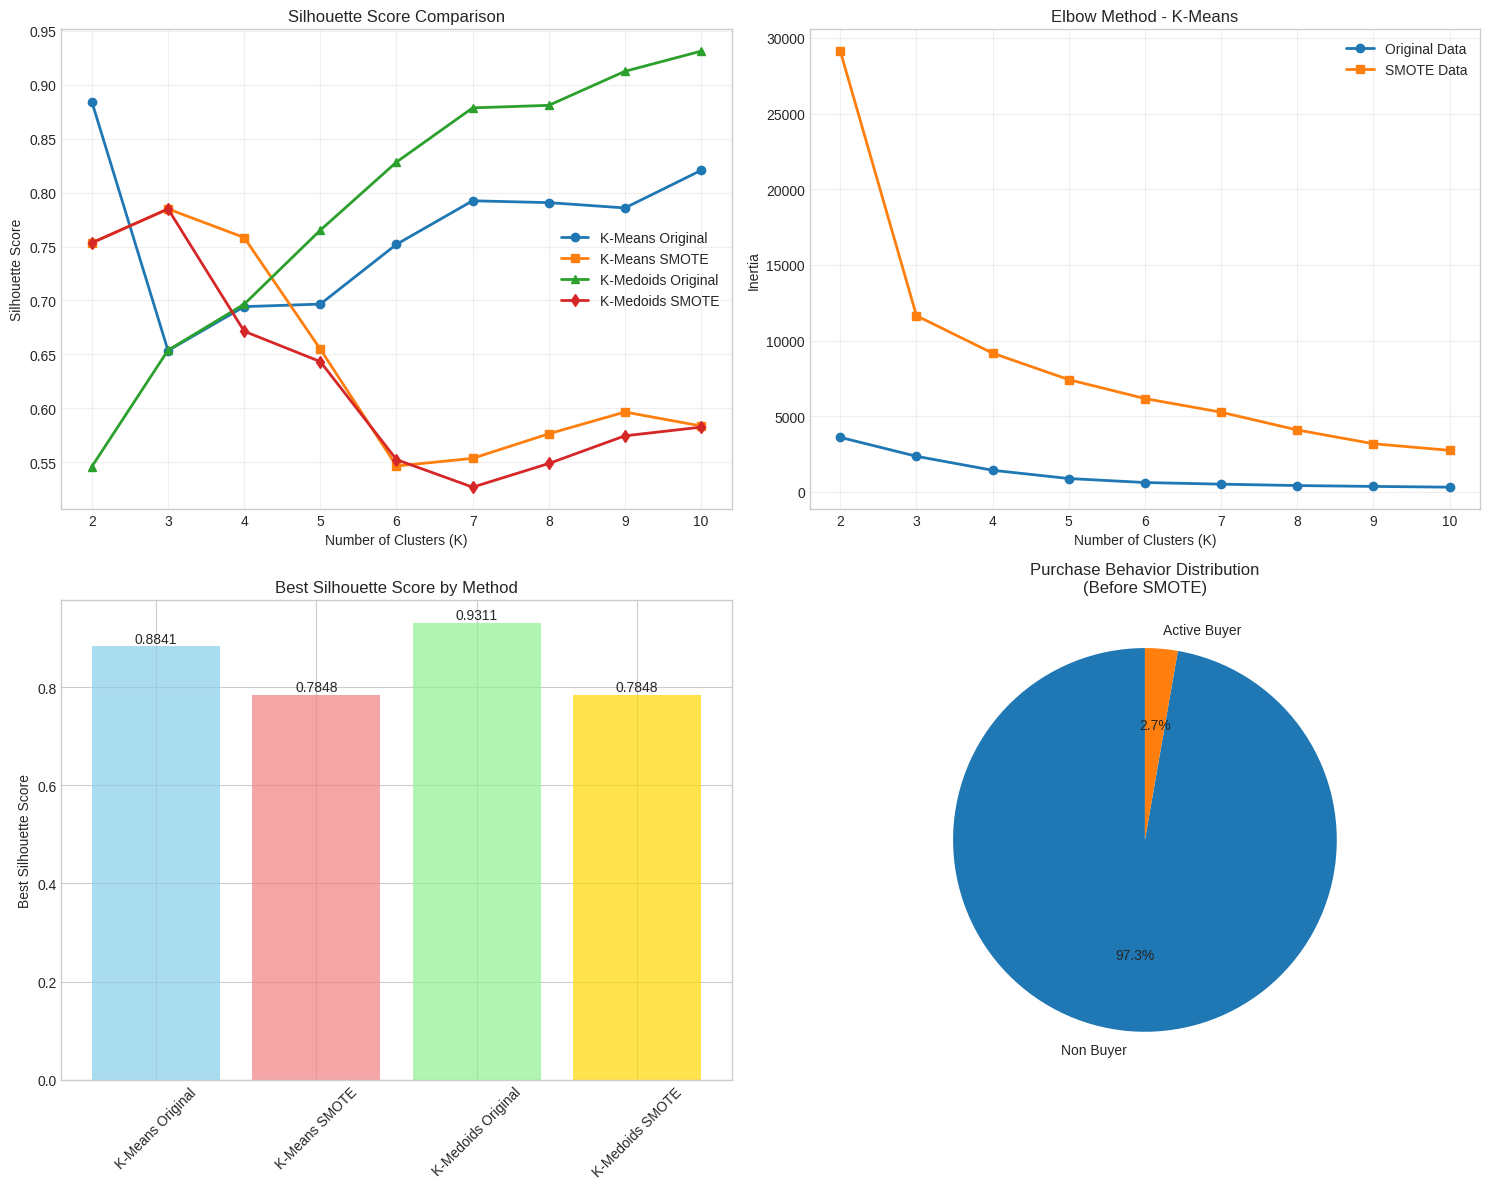

In [28]:
# ===== VISUALISASI HASIL =====
def plot_clustering_results():
    """Visualisasi hasil clustering"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Silhouette Score Comparison
    k_range = list(range(2, 11))

    axes[0, 0].plot(k_range, sil_scores_orig, 'o-', label='K-Means Original', linewidth=2)
    axes[0, 0].plot(k_range, sil_scores_smote, 's-', label='K-Means SMOTE', linewidth=2)
    axes[0, 0].plot(k_range, sil_scores_kmed_orig, '^-', label='K-Medoids Original', linewidth=2)
    axes[0, 0].plot(k_range, sil_scores_kmed_smote, 'd-', label='K-Medoids SMOTE', linewidth=2)
    axes[0, 0].set_xlabel('Number of Clusters (K)')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].set_title('Silhouette Score Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Elbow Method untuk K-Means
    axes[0, 1].plot(k_range, inertias_orig, 'o-', label='Original Data', linewidth=2)
    axes[0, 1].plot(k_range, inertias_smote, 's-', label='SMOTE Data', linewidth=2)
    axes[0, 1].set_xlabel('Number of Clusters (K)')
    axes[0, 1].set_ylabel('Inertia')
    axes[0, 1].set_title('Elbow Method - K-Means')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Best Silhouette Scores Bar Chart
    best_scores = {
        'K-Means Original': max(sil_scores_orig),
        'K-Means SMOTE': max(sil_scores_smote),
        'K-Medoids Original': max(sil_scores_kmed_orig),
        'K-Medoids SMOTE': max(sil_scores_kmed_smote)
    }

    methods = list(best_scores.keys())
    scores = list(best_scores.values())
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

    bars = axes[1, 0].bar(methods, scores, color=colors, alpha=0.7)
    axes[1, 0].set_ylabel('Best Silhouette Score')
    axes[1, 0].set_title('Best Silhouette Score by Method')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Tambahkan nilai di atas bar
    for bar, score in zip(bars, scores):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                       f'{score:.4f}', ha='center', va='bottom')

    # 4. Data Distribution Before/After SMOTE
    axes[1, 1].pie(purchase_labels.value_counts(), labels=purchase_labels.value_counts().index,
                   autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Purchase Behavior Distribution\n(Before SMOTE)')

    plt.tight_layout()
    plt.show()

# Plot hasil clustering
plot_clustering_results()

In [29]:
# ===== ANALISIS CLUSTER TERBAIK =====
def analyze_best_clusters():
    """Analisis cluster terbaik berdasarkan Silhouette Score"""

    # Cari model terbaik
    best_kmeans_orig_k = max(kmeans_results_orig.keys(),
                            key=lambda k: kmeans_results_orig[k]['silhouette_score'])
    best_kmeans_smote_k = max(kmeans_results_smote.keys(),
                             key=lambda k: kmeans_results_smote[k]['silhouette_score'])
    best_kmedoids_orig_k = max(kmedoids_results_orig.keys(),
                              key=lambda k: kmedoids_results_orig[k]['silhouette_score'])
    best_kmedoids_smote_k = max(kmedoids_results_smote.keys(),
                               key=lambda k: kmedoids_results_smote[k]['silhouette_score'])

    print("=== BEST CLUSTERING RESULTS ===")
    print(f"K-Means Original: K={best_kmeans_orig_k}, Silhouette={kmeans_results_orig[best_kmeans_orig_k]['silhouette_score']:.4f}")
    print(f"K-Means SMOTE: K={best_kmeans_smote_k}, Silhouette={kmeans_results_smote[best_kmeans_smote_k]['silhouette_score']:.4f}")
    print(f"K-Medoids Original: K={best_kmedoids_orig_k}, Silhouette={kmedoids_results_orig[best_kmedoids_orig_k]['silhouette_score']:.4f}")
    print(f"K-Medoids SMOTE: K={best_kmedoids_smote_k}, Silhouette={kmedoids_results_smote[best_kmedoids_smote_k]['silhouette_score']:.4f}")

    # Tentukan model terbaik overall
    all_scores = {
        'K-Means Original': kmeans_results_orig[best_kmeans_orig_k]['silhouette_score'],
        'K-Means SMOTE': kmeans_results_smote[best_kmeans_smote_k]['silhouette_score'],
        'K-Medoids Original': kmedoids_results_orig[best_kmedoids_orig_k]['silhouette_score'],
        'K-Medoids SMOTE': kmedoids_results_smote[best_kmedoids_smote_k]['silhouette_score']
    }

    best_method = max(all_scores.keys(), key=lambda k: all_scores[k])
    print(f"\n=== OVERALL BEST METHOD ===")
    print(f"Method: {best_method}")
    print(f"Silhouette Score: {all_scores[best_method]:.4f}")

    return {
        'best_method': best_method,
        'best_score': all_scores[best_method],
        'all_scores': all_scores
    }

In [30]:
# Analisis cluster terbaik
best_results = analyze_best_clusters()

=== BEST CLUSTERING RESULTS ===
K-Means Original: K=2, Silhouette=0.8841
K-Means SMOTE: K=3, Silhouette=0.7848
K-Medoids Original: K=10, Silhouette=0.9311
K-Medoids SMOTE: K=3, Silhouette=0.7848

=== OVERALL BEST METHOD ===
Method: K-Medoids Original
Silhouette Score: 0.9311


In [31]:
# ===== VISUALISASI CLUSTER DENGAN PCA =====
def visualize_clusters_pca(X, labels, method_name, n_components=2):
    """Visualisasi cluster menggunakan PCA"""

    # PCA untuk dimensionality reduction
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'Cluster Visualization - {method_name}')
    plt.grid(True, alpha=0.3)

    # Tambahkan informasi cluster
    unique_labels = np.unique(labels)
    for label in unique_labels:
        mask = labels == label
        center = X_pca[mask].mean(axis=0)
        plt.annotate(f'C{label}', center, fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total Variance Explained: {pca.explained_variance_ratio_.sum():.2%}")

# Visualisasi untuk model terbaik
if best_results['best_method'] == 'K-Means Original':
    best_k = max(kmeans_results_orig.keys(), key=lambda k: kmeans_results_orig[k]['silhouette_score'])
    best_labels = kmeans_results_orig[best_k]['labels']
    visualize_clusters_pca(X_scaled, best_labels, 'K-Means Original (Best)')
elif best_results['best_method'] == 'K-Means SMOTE':
    best_k = max(kmeans_results_smote.keys(), key=lambda k: kmeans_results_smote[k]['silhouette_score'])
    best_labels = kmeans_results_smote[best_k]['labels']
    visualize_clusters_pca(X_smote, best_labels, 'K-Means SMOTE (Best)')

In [32]:
# ===== INTERPRETASI CLUSTER =====
def interpret_clusters(X, labels, feature_names, method_name):
    """Interpretasi karakteristik setiap cluster"""

    # Buat DataFrame untuk analisis
    df_analysis = pd.DataFrame(X, columns=feature_names)
    df_analysis['Cluster'] = labels

    print(f"\n=== CLUSTER INTERPRETATION - {method_name} ===")

    # Statistik per cluster
    cluster_stats = df_analysis.groupby('Cluster').agg(['mean', 'median', 'std'])

    # Heatmap karakteristik cluster
    cluster_means = df_analysis.groupby('Cluster')[feature_names].mean()

    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', center=0, fmt='.2f')
    plt.title(f'Cluster Characteristics Heatmap - {method_name}')
    plt.xlabel('Cluster')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    # Ukuran cluster
    cluster_sizes = pd.Series(labels).value_counts().sort_index()
    print("\nCluster Sizes:")
    for cluster, size in cluster_sizes.items():
        percentage = (size / len(labels)) * 100
        print(f"Cluster {cluster}: {size} customers ({percentage:.1f}%)")

    # Karakteristik dominan per cluster
    print("\nCluster Characteristics:")
    for cluster in sorted(cluster_means.index):
        print(f"\nCluster {cluster}:")
        cluster_profile = cluster_means.loc[cluster]

        # Identifikasi karakteristik tertinggi dan terendah
        top_features = cluster_profile.nlargest(3)
        bottom_features = cluster_profile.nsmallest(3)

        print(f"  High: {', '.join([f'{feat}={val:.2f}' for feat, val in top_features.items()])}")
        print(f"  Low: {', '.join([f'{feat}={val:.2f}' for feat, val in bottom_features.items()])}")

    return cluster_stats, cluster_means

# Interpretasi untuk model terbaik
if best_results['best_method'] == 'K-Means Original':
    best_k = max(kmeans_results_orig.keys(), key=lambda k: kmeans_results_orig[k]['silhouette_score'])
    best_labels = kmeans_results_orig[best_k]['labels']
    cluster_stats, cluster_means = interpret_clusters(X_scaled, best_labels, available_features, 'K-Means Original')
elif best_results['best_method'] == 'K-Means SMOTE':
    best_k = max(kmeans_results_smote.keys(), key=lambda k: kmeans_results_smote[k]['silhouette_score'])
    best_labels = kmeans_results_smote[best_k]['labels']
    cluster_stats, cluster_means = interpret_clusters(X_smote, best_labels, available_features, 'K-Means SMOTE')

In [33]:
# ===== SUMMARY HASIL =====
print("\n" + "="*60)
print("SUMMARY HASIL CLUSTERING")
print("="*60)

print(f"Dataset Size: {df.shape[0]:,} transactions")
print(f"Unique Customers: {len(data):,}")
print(f"Features Used: {len(available_features)}")

print(f"\nBest Method: {best_results['best_method']}")
print(f"Best Silhouette Score: {best_results['best_score']:.4f}")

print("\nAll Method Comparison:")
for method, score in best_results['all_scores'].items():
    print(f"  {method}: {score:.4f}")

print("\nImpact of SMOTE:")
smote_improvement_kmeans = max(sil_scores_smote) - max(sil_scores_orig)
smote_improvement_kmedoids = max(sil_scores_kmed_smote) - max(sil_scores_kmed_orig)
print(f"  K-Means improvement: {smote_improvement_kmeans:+.4f}")
print(f"  K-Medoids improvement: {smote_improvement_kmedoids:+.4f}")

print("\n" + "="*60)
print("CLUSTERING MODEL COMPLETED!")
print("="*60)


SUMMARY HASIL CLUSTERING
Dataset Size: 5,000 transactions
Unique Customers: 1,747
Features Used: 6

Best Method: K-Medoids Original
Best Silhouette Score: 0.9311

All Method Comparison:
  K-Means Original: 0.8841
  K-Means SMOTE: 0.7848
  K-Medoids Original: 0.9311
  K-Medoids SMOTE: 0.7848

Impact of SMOTE:
  K-Means improvement: -0.0993
  K-Medoids improvement: -0.1463

CLUSTERING MODEL COMPLETED!
